<a href="https://colab.research.google.com/github/anilaq/capstone/blob/master/latest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Recommendation System for Anime

Anime, is a hand drawn and computer animation originating from Japan which is widely drawn a cult following around the world. The animation industry consists of more than 430 companies. Some of the most popular anime that has come to Western television is Pokemon and Yugi-Oh ."Spirited Away" a film created by Hayao Miyazaki and animated by Studio Ghibli is the highest grossing film within the anime genre. The reason it became so popular in the west is because a good friend of Miyazaki convinced him to sell distribution rights to Walt Disney. Like Spirited Away, there are thousands of really good anime films and shows produced by the same animation house. Due to the pandemic a nice way to bring such works of art into Disney plus or any streaming site in the West I have created a recommendation system that can help anyone or any company to view/add the highest rated anime. The Japan External Trade Organization has valued overseas sales to  18𝑏𝑖𝑙𝑙𝑖𝑜𝑛( 5.2 billion for the US alone) in 2004. This has likely grown. With covid19 looming over Japan which has caused one of the first long term recessions for the country. A way at which potential growth could take place is focusing on streaming and producing more of the top recommended. 

In [1]:
!pip install surprise

     |████████████████████████████████| 6.5MB 2.6MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.0-cp36-cp36m-linux_x86_64.whl size=1675383 sha256=c484edef65cba54062194a0419a6a4708102ac0264f1c15dbd50d6c88966f147
  Stored in directory: /root/.cache/pip/wheels/cc/fa/8c/16c93fccce688ae1bde7d979ff102f7bee980d9cfeb8641bcf
Successfully built scikit-surprise


In [2]:
import pandas as pd 

import numpy as np 

import random
from random import randint

import matplotlib.pyplot as plt 
%matplotlib inline 
import seaborn as sns 

from scipy.sparse import csc_matrix
from scipy.sparse.linalg import svds 

from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV
from surprise.model_selection import cross_validate

from surprise.prediction_algorithms import KNNWithMeans, KNNBasic, KNNBaseline

from surprise.prediction_algorithms import knns
from surprise.prediction_algorithms import SVD

from surprise.similarities import cosine, msd, pearson

from surprise import accuracy 
from surprise import Reader
from surprise import Dataset
from surprise import dataset



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Preprocessing

In [3]:
anime_df = pd.read_csv('./anime.csv')
anime_df.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [4]:
anime_df.shape

(12294, 7)

In [0]:
anime_df.dropna(inplace=True)

*** There are 12,294 rows above, and need to drop any null values ***

In [6]:
anime_df.shape #this seemed to have reduced it down a bit

(12017, 7)

## What each column represents: 
***anime_id: id number for each anime title***<br>
***name:  title of the motion picture***<br>
***genre:  category***<br>
***type:  describes the anime into tv, movies, OVA, and 3 other categories***<br>
***episodes: total number of episodes ***<br>
***rating: -1-10, lowest to highest*** <br>
***members:  number of community members that are in this anime group***<br>

In [7]:
anime_df.info() #having a look at all of the columns and types from the above cell and current to remove 
#any unneccessary extraneous data

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12017 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12017 non-null  int64  
 1   name      12017 non-null  object 
 2   genre     12017 non-null  object 
 3   type      12017 non-null  object 
 4   episodes  12017 non-null  object 
 5   rating    12017 non-null  float64
 6   members   12017 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 751.1+ KB


In [8]:
rating_df = pd.read_csv('./rating.csv')
rating_df.head()

,user_id,anime_id,rating
0,1,20,-1.0
1,1,24,-1.0
2,1,79,-1.0
3,1,226,-1.0
4,1,241,-1.0


## What each column represents: 
*** user_id: non-identifiable randomly generated user id*** <br>
*** anime_id: the anime that the user has rated *** <br>
*** rating: rating out of 10 this user has assigned (-1 if the user watched it but didn't assign a rating) ***

In [9]:
rating_df.shape

(1393382, 3)

Need to join both datasets together, will join using anime_id then hopefully will reshuffle the dataset so that it can be transformed into something that is compatible with `surprise`. 

I will join the two dataframes by merging them so that they can correspond to the correct anime_ids

In [10]:
df_merge = pd.merge(anime_df, rating_df, on = 'anime_id')
df_merge.head()
# df_merge = df_row.merge(rating_df, left_on= 'anime_id', how='outer')
# df_merge.head()

,anime_id,name,genre,type,episodes,rating_x,members,user_id,rating_y
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,99,5.0
1,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,152,10.0
2,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,244,10.0
3,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,271,10.0
4,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,278,-1.0


In [11]:
df_merge.shape 

(1393345, 9)

*** The data here is extremely large. Because I will be using Singular Value Decomposition (SVD) which is known to be computationally expensive I will be taking a large sample from the 7.8 million rows. Before taking a sample I will remove the -1 ratings from the dataset since these don't really count as reviews ***

In [12]:
df_merge.rating_x.min()

2.0

In [13]:
df_merge = df_merge[df_merge.rating_y != -1]
df_merge.head()

,anime_id,name,genre,type,episodes,rating_x,members,user_id,rating_y
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,99,5.0
1,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,152,10.0
2,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,244,10.0
3,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,271,10.0
5,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,322,10.0


In [14]:
df_merge.shape #have removed over 1 million rows

(1134158, 9)

In [15]:
sample = df_merge.sample(frac=.25)
sample.shape # this is still too large

(283540, 9)

In [16]:
sample = df_merge.sample(n=5000)
sample.shape #below I conduct SVD and it cannot handle anything larger than 5000 (i've tried)

(5000, 9)

###It seems that the rating dataframe is based on each user and their individual rating for each anime id, whereas the anime dataframe is an average overall rating from all of its viewers.  

In [17]:
#we are going to look at how many times each rating appears in a column
ratings_x = sample['rating_x'].value_counts() #continuous 
ratings_y = sample['rating_y'].value_counts() #discrete

print(ratings_x)
print(ratings_y)

8.06    71
7.81    66
7.88    53
7.55    50
7.40    47
        ..
5.42     1
6.18     1
5.29     1
9.16     1
6.16     1
Name: rating_x, Length: 332, dtype: int64
8.0     1326
7.0     1073
9.0      997
10.0     706
6.0      518
5.0      238
4.0       75
3.0       36
2.0       18
1.0       13
Name: rating_y, dtype: int64


In [18]:
sample.rating_x = sample.rating_x.apply(round) #another important feature i have had to add is making all ratings discrete for SVD
sample.head()

,anime_id,name,genre,type,episodes,rating_x,members,user_id,rating_y
1009672,274,Kiddy Grade,"Action, Ecchi, Mecha, Sci-Fi, Super Power",TV,24,7,30766,5249,8.0
839902,1691,Kaze no Stigma,"Action, Fantasy, Magic, Romance, Shounen",TV,24,8,205338,806,9.0
978673,195,Onegai☆Teacher,"Comedy, Drama, Romance, School, Sci-Fi",TV,12,7,99558,10720,7.0
557723,1719,Rozen Maiden: Ouvertüre,"Action, Comedy, Drama, Magic, Seinen",Special,2,8,44388,7711,8.0
472777,93,Mobile Suit Gundam Seed,"Action, Drama, Mecha, Military, Romance, Sci-F...",TV,50,8,96973,10833,9.0


## Distribution of User Ratings

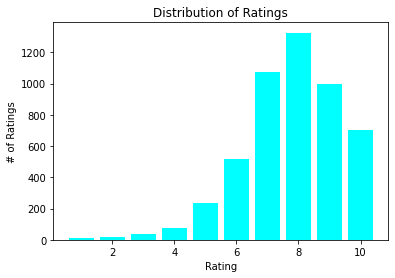

In [19]:
# plot distribution in matplotlib
ratings_sorted = sorted(list(zip(ratings_y.index, ratings_y)))
plt.bar([r[0] for r in ratings_sorted], [r[1] for r in ratings_sorted], color='cyan')
plt.xlabel("Rating")
plt.ylabel("# of Ratings")
plt.title("Distribution of Ratings")
plt.show()

In [20]:
#number of users
print("Number of Users:", df_merge.user_id.nunique())
# print("Average Number of Reviews per User:", df_merge.shape[0])/df_merge.user_id.nunique()
avg_rate_peruser = df_merge.shape[0]
user = df_merge.user_id.nunique()
avg_num_review_per_user = avg_rate_peruser/user
print("Average Number of Reveiws per User:", avg_num_review_per_user)

Number of Users: 12565
Average Number of Reveiws per User: 90.26327099084759


In [21]:
sample['user_id'].value_counts()

7345     12
12431    11
9032     10
1530     10
7249      9
         ..
4952      1
4948      1
4944      1
4936      1
2049      1
Name: user_id, Length: 3214, dtype: int64

## Number of Reviews per User

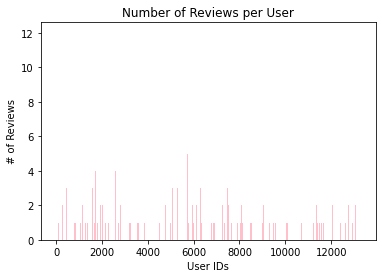

In [22]:
ratings_per_user = sample['user_id'].value_counts()
ratings_per_user = sorted(list(zip(ratings_per_user.index, ratings_per_user)))
plt.bar([r[0] for r in ratings_per_user], [r[1] for r in ratings_per_user], color='pink')
plt.xlabel('User IDs')
plt.ylabel('# of Reviews')
plt.title('Number of Reviews per User')
plt.show()

In [0]:
#graph on user ratings, what are the most common scores given 

## Different types of anime videos

In [24]:
print("Number of users:", sample.user_id.nunique())
print("Number of types of different anime:", sample.type.nunique())
print("Types of type:", sample.type.value_counts())

Number of users: 3214
Number of types of different anime: 6
Types of type: TV         3401
Movie       675
OVA         516
Special     339
ONA          60
Music         9
Name: type, dtype: int64


This means that there are six different categories for anime: <br>
Movies, TV, OVA, Special, ONA and Music. <br>
***OVA stands for orginal animation video, this has been released directly to the video market <br>
Special is not a common occuring video, it is usually shot yearly or on a one off <br>
Music is not just audio here, but a lively animated motion picture to go with the composed music piece ***

In [25]:
sample_of_sample = sample[:100] #taking a sample to see if its the amount of data or its the command given
sample_of_sample

,anime_id,name,genre,type,episodes,rating_x,members,user_id,rating_y
1009672,274,Kiddy Grade,"Action, Ecchi, Mecha, Sci-Fi, Super Power",TV,24,7,30766,5249,8.0
839902,1691,Kaze no Stigma,"Action, Fantasy, Magic, Romance, Shounen",TV,24,8,205338,806,9.0
978673,195,Onegai☆Teacher,"Comedy, Drama, Romance, School, Sci-Fi",TV,12,7,99558,10720,7.0
557723,1719,Rozen Maiden: Ouvertüre,"Action, Comedy, Drama, Magic, Seinen",Special,2,8,44388,7711,8.0
472777,93,Mobile Suit Gundam Seed,"Action, Drama, Mecha, Military, Romance, Sci-F...",TV,50,8,96973,10833,9.0
...,...,...,...,...,...,...,...,...,...
1164866,229,Ninin ga Shinobuden,"Comedy, Martial Arts, Parody",TV,12,7,23125,5889,4.0
1123861,903,Dragon Ball Z Movie 10: Kiken na Futari! Super...,"Action, Adventure, Comedy, Demons, Fantasy, Ma...",Movie,1,7,54947,9575,9.0
1222128,5526,Pokemon: Pikachu no Natsuyasumi,"Comedy, Fantasy, Kids",Movie,1,7,19960,10905,7.0
1093747,1118,Pokemon: Kesshoutou no Teiou Entei,"Action, Adventure, Comedy, Drama, Fantasy, Kids",Movie,1,7,73253,10788,7.0


In [26]:
sample.loc[sample['type'] == 'Movie']

,anime_id,name,genre,type,episodes,rating_x,members,user_id,rating_y
635486,371,Cardcaptor Sakura Movie 1,"Comedy, Drama, Fantasy, Magic, Shoujo",Movie,1,8,56327,5777,6.0
281897,437,Perfect Blue,"Dementia, Drama, Horror, Psychological",Movie,1,8,117565,8186,9.0
989053,2847,Pokemon Diamond &amp; Pearl: Dialga vs. Palkia...,"Action, Adventure, Comedy, Drama, Fantasy, Kids",Movie,1,7,38238,10926,7.0
136183,572,Kaze no Tani no Nausicaä,"Adventure, Fantasy",Movie,1,8,143273,10531,10.0
530931,8514,Break Blade 2: Ketsubetsu no Michi,"Action, Fantasy, Mecha, Military, Shounen",Movie,1,8,44900,5228,7.0
...,...,...,...,...,...,...,...,...,...
736366,901,"Dragon Ball Z Movie 08: Moetsukiro!! Nessen, R...","Adventure, Comedy, Fantasy, Sci-Fi, Shounen",Movie,1,8,65953,10070,7.0
784988,1911,Top wo Nerae! &amp; Top wo Nerae 2! Gattai Mov...,"Comedy, Mecha, Shounen",Movie,2,8,8079,10603,8.0
704770,4835,Bleach Movie 3: Fade to Black - Kimi no Na wo ...,"Action, Comedy, Shounen, Super Power, Supernat...",Movie,1,8,122373,6700,10.0
465795,16904,K: Missing Kings,"Action, Super Power, Supernatural",Movie,1,8,98549,2874,9.0


In [27]:
len(sample.loc[sample['type'] == 'TV']) #How many tv shows there are in the dataframe

3401

In [28]:
len(sample.loc[sample['type'] == 'Movie'])

675

In [29]:
sample.loc[sample['type'] == 'Movie'].rating_x.value_counts() #Viewer ratings for films 

8    415
7    166
9     76
6     17
4      1
Name: rating_x, dtype: int64

In [30]:
sample.loc[sample['type'] == 'Movie'].rating_y.value_counts() #Viewer ratings for films 

8.0     181
7.0     157
9.0     132
10.0     99
6.0      68
5.0      29
4.0       3
1.0       3
2.0       2
3.0       1
Name: rating_y, dtype: int64

***drop rows containing -1 as rating in df_merge ***
could be that I have an approximation error 

*** Look at min ratings in rating_x *** if its a rating error, we would recreate y based off of x. (round to a whole number) *** 0 decimal places

## Most Reviewed Videos

In [31]:
movies_review = len(sample.loc[sample['type'] == 'Movie'])
movies_review

675

In [32]:
tv_reviews = len(sample.loc[sample['type'] == 'TV'])
tv_reviews

3401

In [33]:
ova_reviews = len(sample.loc[sample['type'] =='OVA'])
ova_reviews

516

In [34]:
music_reviews = len(sample.loc[sample['type'] =='Music'])
music_reviews

9

In [35]:
ona_reviews = len(sample.loc[sample['type'] =='ONA'])
ona_reviews

60

In [36]:
special_reviews = len(sample.loc[sample['type'] =='Special'])
special_reviews

339

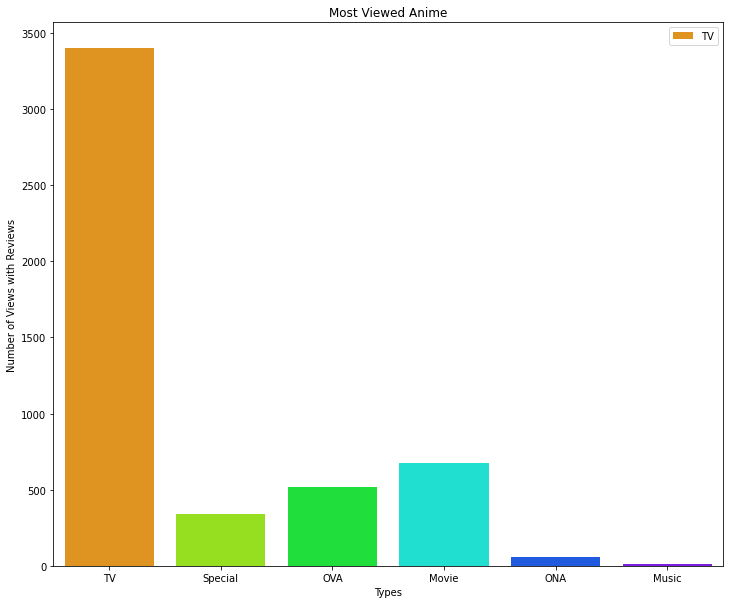

In [37]:
# PLOT them 
fig = plt.figure(figsize=(12,10))
sns.countplot(sample['type'], palette='gist_rainbow')
plt.title("Most Viewed Anime")
plt.xlabel("Types")
plt.ylabel("Number of Views with Reviews")
plt.legend(sample['type'])
plt.show()

In [38]:
len(sample)

5000

# Implementing a Surprise's Singular Value Decomposition (SVD) as a Baseline

In [39]:
sample.rating_x = sample.rating_x.apply(round)
sample.head()

,anime_id,name,genre,type,episodes,rating_x,members,user_id,rating_y
1009672,274,Kiddy Grade,"Action, Ecchi, Mecha, Sci-Fi, Super Power",TV,24,7,30766,5249,8.0
839902,1691,Kaze no Stigma,"Action, Fantasy, Magic, Romance, Shounen",TV,24,8,205338,806,9.0
978673,195,Onegai☆Teacher,"Comedy, Drama, Romance, School, Sci-Fi",TV,12,7,99558,10720,7.0
557723,1719,Rozen Maiden: Ouvertüre,"Action, Comedy, Drama, Magic, Seinen",Special,2,8,44388,7711,8.0
472777,93,Mobile Suit Gundam Seed,"Action, Drama, Mecha, Military, Romance, Sci-F...",TV,50,8,96973,10833,9.0


In [0]:
#for surprise, it likes its data in a certain way and only that specific data
data = sample[['user_id', 'anime_id', 'rating_x']] #may need to do rating_x rounded and then use rating_y
reader = Reader(line_format='user item rating', sep='')
anime_loaded_data = Dataset.load_from_df(data, reader)
# anime_split = anime_loaded_data.split(n_folds=5) 

#train_test_split
trainset, testset = train_test_split(anime_loaded_data, test_size=.2)

In [41]:
anime_loaded_data

In [42]:
#INSTANTIATE the SVD and fit only the train set
svd = SVD()
svd.fit(trainset)

In [43]:
predictions = svd.test(testset) #
accuracy.rmse(predictions)

RMSE: 2.7194


2.7193749281774293

*** I don't think this is better than the .66 that I have above on the memory based models.***

In [44]:
predictions[:10]

[Prediction(uid=746, iid=5681, r_ui=8.0, est=5, details={'was_impossible': False}),
 Prediction(uid=10497, iid=7222, r_ui=8.0, est=5, details={'was_impossible': False}),
 Prediction(uid=2204, iid=2167, r_ui=8.0, est=5, details={'was_impossible': False}),
 Prediction(uid=7823, iid=4898, r_ui=8.0, est=5, details={'was_impossible': False}),
 Prediction(uid=9873, iid=223, r_ui=8.0, est=5, details={'was_impossible': False}),
 Prediction(uid=1711, iid=25681, r_ui=8.0, est=5, details={'was_impossible': False}),
 Prediction(uid=9044, iid=16904, r_ui=8.0, est=5, details={'was_impossible': False}),
 Prediction(uid=7249, iid=18119, r_ui=8.0, est=5, details={'was_impossible': False}),
 Prediction(uid=3127, iid=5675, r_ui=7.0, est=5, details={'was_impossible': False}),
 Prediction(uid=2362, iid=11757, r_ui=8.0, est=5, details={'was_impossible': False})]

In [45]:
print("Number of users:", sample.user_id.nunique())
print("Number of types of different anime:", sample.type.nunique())


Number of users: 3214
Number of types of different anime: 6


In [46]:
user = 5
item = 100
svd.predict(user, item)

Prediction(uid=5, iid=100, r_ui=None, est=5, details={'was_impossible': False})

Now I need to compare the different models and see which ones perform best. I will stick to using RMSE to evaluate the models. I will also cross validate. 

In [47]:
#perform a gridsearch CV
params = {'n_factors': [20,50,100],
         'reg_all': [.02,.05, .10]}
gridsearch_svd1 = GridSearchCV(SVD, param_grid=params, n_jobs=-1, joblib_verbose=3)
gridsearch_svd1.fit(anime_loaded_data)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   11.8s finished


In [48]:
print(gridsearch_svd1.best_score)
print(gridsearch_svd1.best_params)

{'rmse': 2.738190607629976, 'mae': 2.645}
{'rmse': {'n_factors': 20, 'reg_all': 0.02}, 'mae': {'n_factors': 20, 'reg_all': 0.02}}


**Better than the model before***

In [49]:
anime_loaded_data

## Cross Validation with K-Nearest Neighbors (KNN) Basic Algorithm

In [50]:
#cross validate with KNNBasic
knn_basic = KNNBasic(sim_options={'name':'pearson', 'user_based':True}, verbose=True)
cv_knn_basic = cross_validate(knn_basic, anime_loaded_data, n_jobs=2)

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [51]:
for i in cv_knn_basic.items():
    print(i)
print('-----------------')
print(np.mean(cv_knn_basic['test_rmse']))

('test_rmse', array([2.71311629, 2.74408455, 2.70721259, 2.76568256, 2.76079699]))
('test_mae', array([2.617, 2.646, 2.619, 2.673, 2.67 ]))
('fit_time', (0.8272240161895752, 0.9396998882293701, 0.6461565494537354, 0.5406589508056641, 0.31038761138916016))
('test_time', (0.02841329574584961, 0.015196084976196289, 0.013674259185791016, 0.013736486434936523, 0.008034944534301758))
-----------------
2.7381785934277003


*** This is not as good as the baseline***

In [0]:
knn_basic_msd = KNNBasic(sim_options = {'name': 'msd', 'user-based':True})
cv_knn_basic_msd = cross_validate(knn_basic_msd, anime_loaded_data, n_jobs=2)

In [53]:
for i in cv_knn_basic_msd.items():
    print(i)
print('-----------------')
print(np.mean(cv_knn_basic_msd['test_rmse']))

('test_rmse', array([2.74517759, 2.73605555, 2.73660373, 2.74899982, 2.72451831]))
('test_mae', array([2.658, 2.644, 2.637, 2.655, 2.631]))
('fit_time', (0.4238736629486084, 0.4982161521911621, 0.4042820930480957, 0.3780038356781006, 0.2330150604248047))
('test_time', (0.014336347579956055, 0.027400732040405273, 0.028580904006958008, 0.01326441764831543, 0.00812840461730957))
-----------------
2.7382710007198514


*** better than the model above ***


## Cross Validation with KNN Baseline

In [0]:
#cross validate with KNN Baseline (pearson)
knn_baseline = KNNBaseline(sim_options={'name': 'pearson', 'user_based':True})
cv_knn_baseline = cross_validate(knn_baseline, anime_loaded_data, n_jobs=3)

In [55]:
for i in cv_knn_baseline.items():
    print(i)
print('-----------------')
print(np.mean(cv_knn_baseline['test_rmse']))

('test_rmse', array([2.71330057, 2.73843021, 2.75862284, 2.74244417, 2.73843021]))
('test_mae', array([2.62 , 2.637, 2.668, 2.653, 2.647]))
('fit_time', (0.4852302074432373, 0.6489777565002441, 0.7868297100067139, 0.7068839073181152, 0.499464750289917))
('test_time', (0.016990184783935547, 0.03343486785888672, 0.0081329345703125, 0.013344526290893555, 0.01479339599609375))
-----------------
2.7382455995551527


***better than the other rmse but not as good as mae from above *** 

In [0]:
knn_baseline_msd = KNNBaseline(sim_options = {'name': 'msd', 'user_based': True})
cv_knn_baseline_msd = cross_validate(knn_baseline_msd, anime_loaded_data, n_jobs =2)

In [57]:
for i in cv_knn_baseline_msd.items():
  print(i)
print('-------------------')
print(np.mean(cv_knn_baseline_msd['test_rmse']))

('test_rmse', array([2.7491817 , 2.73276417, 2.72525228, 2.7342275 , 2.74990909]))
('test_mae', array([2.658, 2.642, 2.631, 2.646, 2.648]))
('fit_time', (0.37298059463500977, 0.3625175952911377, 0.39357948303222656, 0.38887572288513184, 0.23233485221862793))
('test_time', (0.013696908950805664, 0.014677762985229492, 0.023014068603515625, 0.013303518295288086, 0.01012730598449707))
-------------------
2.7382669464287313


*** Not as good as the above ***

## Cross Validate with KNNBaseline using pearson baseline

In [0]:
knn_pearson_baseline = KNNBaseline(sim_options={'name': 'pearson_baseline', 'user_based':True})
cv_knn_pearson_baseline = cross_validate(knn_pearson_baseline, anime_loaded_data, n_jobs=3)

In [59]:
for i in cv_knn_pearson_baseline.items():
  print(i)
print('-------------------')
print(np.mean(cv_knn_pearson_baseline['test_rmse']))

('test_rmse', array([2.71919106, 2.71348484, 2.75753513, 2.75826032, 2.74262648]))
('test_mae', array([2.626, 2.621, 2.664, 2.664, 2.65 ]))
('fit_time', (0.4426238536834717, 0.4328491687774658, 0.5683281421661377, 0.49898815155029297, 0.4249231815338135))
('test_time', (0.01666116714477539, 0.021939516067504883, 0.012817144393920898, 0.013846158981323242, 0.015468835830688477))
-------------------
2.738219566270913


*** hmmmm... this is a realistic number for an average rmse score but varies greatly from the other scores, looks similar to the models I added in at the top ***

## KNN with Means 

In [0]:
knn_means = KNNWithMeans(sim_options={'name': 'pearson', 'user_based': True})
cv_knn_means = cross_validate(knn_means, anime_loaded_data, n_jobs=3)

In [61]:
for i in cv_knn_means.items():
  print(i)
print('------------')
print(np.mean(cv_knn_means['test_rmse']))

('test_rmse', array([2.71090391, 2.74007299, 2.73824761, 2.74011861, 2.76242647]))
('test_mae', array([2.621 , 2.65  , 2.648 , 2.6395, 2.667 ]))
('fit_time', (0.5738744735717773, 0.647700309753418, 0.7156872749328613, 0.6148128509521484, 0.43088507652282715))
('test_time', (0.03454136848449707, 0.014249801635742188, 0.029691457748413086, 0.014998435974121094, 0.008639812469482422))
------------
2.738353919002121


In [0]:
knn_means_msd = KNNWithMeans(sim_options={'name': 'msd', 'user_based':True})
cv_knn_means_msd = cross_validate(knn_means_msd, anime_loaded_data, n_jobs = 2)

In [63]:
for i in cv_knn_means_msd.items():
  print(i)
print('-------------')
print(np.mean(cv_knn_means_msd['test_rmse']))

('test_rmse', array([2.71955879, 2.71293199, 2.72511468, 2.79749888, 2.73733447]))
('test_mae', array([2.622 , 2.624 , 2.6295, 2.712 , 2.639 ]))
('fit_time', (0.3162648677825928, 0.5089662075042725, 0.3953084945678711, 0.35918235778808594, 0.2595798969268799))
('test_time', (0.013842582702636719, 0.01462101936340332, 0.017444849014282227, 0.013962984085083008, 0.0077211856842041016))
-------------
2.7384877620586456


*** This is a lot better than the KNNBaseline ***

## Tuning the Best Algorithm with GridSearchCV
Best model so far is KNN Baseline with Mean Squared Distance

In [64]:
param_grid = {'n_factors': [5, 20, 100], 
              'n_epochs': [5,10], 
              'lr_all': [.002, .005], 
              'reg_all': [.02, .05, .5]}
knn_withmeans_gs = GridSearchCV(KNNWithMeans, param_grid=param_grid, n_jobs=3, joblib_verbose=3)
knn_withmeans_gs.fit(anime_loaded_data)

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    7.5s
[Parallel(n_jobs=3)]: Done 122 tasks      | elapsed:   33.0s
[Parallel(n_jobs=3)]: Done 180 out of 180 | elapsed:   48.0s finished


In [65]:
print(knn_withmeans_gs.best_score)
print(knn_withmeans_gs.best_params)

{'rmse': 2.7384489304896413, 'mae': 2.6452}
{'rmse': {'n_factors': 5, 'n_epochs': 5, 'lr_all': 0.002, 'reg_all': 0.02}, 'mae': {'n_factors': 5, 'n_epochs': 5, 'lr_all': 0.002, 'reg_all': 0.02}}


In [0]:
#Now use this to fit test set, initial gridsearch was 2.77096, so will use that gs here
highest_perf_algo = gridsearch_svd1.best_estimator['rmse']

In [67]:
#retrain the whole set
trainset = anime_loaded_data.build_full_trainset()
highest_perf_algo.fit(trainset)

In [68]:
#Biased Accuracy on trainset
predictions = highest_perf_algo.test(trainset.build_testset())
print('Biased accuracy on Trainset', end='')
accuracy.rmse(predictions)

Biased accuracy on TrainsetRMSE: 2.7383


2.7382841342709487

In [69]:
#UnBiased Accuracy on testset
predictions = highest_perf_algo.test(testset)
print('Unbiased Accuracy on test', end='')
accuracy.rmse(predictions)

Unbiased Accuracy on testRMSE: 2.7194


2.7193749281774293

# Collaborative Models

In [0]:
class MyDataset(dataset.DatasetAutoFolds):
  #surprise.dataset.DatasetAutoFolds creates a surprise friendly dataset
  #this will give it folds so that cross validation can be performed efficiently
  def __init__(self, sample, reader):
    self.sample = [(uid, iid, r, None) for (uid, iid, r) in 
                   zip (sample['user_id'], sample['anime_id'], sample['rating_x'])]
    self.reader = reader

In [0]:
# #instantiate the reader parser object
#reader = Reader(line_format = 'user item rating', rating_scale = (0.0, 10.0))

In [0]:
# #parse sample set into a surprise friendly dataset
#data = MyDataset(sample, reader)

In [0]:
reader = Reader(line_format = 'user item rating', rating_scale = (0.0, 10.0))
data = sample[['user_id', 'anime_id', 'rating_x']]
anime_data = Dataset.load_from_df(data, reader)

In [74]:
type(data)

pandas.core.frame.DataFrame

# Train Validation Split

In [0]:
trainset, testset = train_test_split(anime_data, test_size=.2)

# Memory Based Knn Method

## KNN Basic with cosine similarity

In [0]:
#cosine similarity 
sim_cos = {'name': 'cosine', 'user_based':True}

#instantiate the model with the similarity setting
knn_sim_cos = knns.KNNBasic(sim_options=sim_cos)

In [77]:
# fit the model
sim_cos_cv = cross_validate(knn_sim_cos, anime_data, measures=['rmse', 'mae'], cv=3,
                            return_train_measures=True, n_jobs=3, verbose=True)

Evaluating RMSE, MAE of algorithm KNNBasic on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.7196  0.6966  0.7528  0.7230  0.0231  
MAE (testset)     0.6048  0.5910  0.6136  0.6031  0.0093  
RMSE (trainset)   0.0000  0.0000  0.0000  0.0000  0.0000  
MAE (trainset)    0.0000  0.0000  0.0000  0.0000  0.0000  
Fit time          0.27    0.42    0.24    0.31    0.08    
Test time         0.03    0.02    0.01    0.02    0.01    


*** 

### The test set is not great but not terribly bad. I am not sure why the train set is not showing up. 

## 2nd Model: KNN Basic (item based)

In [0]:
#cosine similarity 
sim_cos = {'name': 'cosine', 'user_based': False}

#instantiate the knnBasic with sim_cos settings
knn_basic_simcos = knns.KNNBasic(sim_options=sim_cos)


In [79]:
#fit the model 
cv_knn_basic_simcos = cross_validate(knn_basic_simcos, anime_data, measures=['rmse', 'mae'], cv =3, return_train_measures=True, n_jobs=3, verbose=True)

Evaluating RMSE, MAE of algorithm KNNBasic on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.7166  0.7309  0.7222  0.7232  0.0059  
MAE (testset)     0.6025  0.6036  0.6020  0.6027  0.0007  
RMSE (trainset)   0.3652  0.3589  0.3712  0.3651  0.0050  
MAE (trainset)    0.1801  0.1778  0.1901  0.1827  0.0054  
Fit time          0.11    0.14    0.09    0.11    0.02    
Test time         0.02    0.04    0.01    0.02    0.01    


In [0]:
#This one performed better than the last and the trainset is showing up. WOOH!

##3rd Baseline Model: A user based pearson similarity using KNNBasline

In [0]:
sim_pearson = {'name': 'pearson', 'user_based': True}

#instantiate KNNBasline with pearson 
knn_baseline_pearson = knns.KNNBaseline(sim_options=sim_pearson)

In [82]:
#fit and cross validate model 
cv_knnbaseline_simpearson = cross_validate(knn_baseline_pearson, anime_loaded_data, measures=['rmse', 'mae'], cv=3,
                                           return_train_measures=True, n_jobs=2, verbose=True)

Evaluating RMSE, MAE of algorithm KNNBaseline on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    2.7273  2.7496  2.7380  2.7383  0.0091  
MAE (testset)     2.6329  2.6569  2.6453  2.6450  0.0098  
RMSE (trainset)   2.7426  2.7326  2.7373  2.7375  0.0041  
MAE (trainset)    2.6481  2.6388  2.6422  2.6430  0.0038  
Fit time          0.45    0.38    0.25    0.36    0.08    
Test time         0.02    0.03    0.01    0.02    0.01    


### This user based model with sim pearson did not do as well. Again, user based does not produce trainset results

## 4th Model: Item based pearson similarity using KNNBaseline

In [0]:
sim_pearson = {'name':'pearson', 'user_based': False}

#instantiate KNNBasline 
knn_baseline_item = knns.KNNBaseline(sim_options=sim_pearson)

In [84]:
#fit and cross validate
cv_knnbaseline_item = cross_validate(knn_baseline_item, anime_loaded_data, measures=['rmse', 'mae'], cv=3, 
                                     return_train_measures=True, n_jobs=3, verbose=True)

Evaluating RMSE, MAE of algorithm KNNBaseline on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    2.7167  2.7463  2.7517  2.7382  0.0154  
MAE (testset)     2.6257  2.6449  2.6645  2.6450  0.0158  
RMSE (trainset)   2.7479  2.7337  2.7308  2.7375  0.0075  
MAE (trainset)    2.6523  2.6436  2.6332  2.6430  0.0078  
Fit time          0.19    0.17    0.12    0.16    0.03    
Test time         0.02    0.02    0.01    0.02    0.00    


### This model hasn't performed well and also for some reason has not given trainset RMSE and MAE

## 5th Model: User based using KNNWithMeans with pearson 

In [0]:
sim_pearson = {'name': 'pearson', 'user_based': True}

#instantiating KNNWithMeans
knn_withmeans_user = knns.KNNWithMeans(sim_options=sim_pearson)

In [86]:
#fit and cross validate 
cv_knnwithmeans_user = cross_validate(knn_withmeans_user, anime_loaded_data, measures=['rmse','mae'], cv=3, return_train_measures=True, 
                                      n_jobs=3, verbose=True)

Evaluating RMSE, MAE of algorithm KNNWithMeans on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    2.7223  2.7388  2.7548  2.7386  0.0133  
MAE (testset)     2.6320  2.6419  2.6621  2.6453  0.0125  
RMSE (trainset)   2.7453  2.7374  2.7297  2.7375  0.0063  
MAE (trainset)    2.6490  2.6451  2.6350  2.6430  0.0059  
Fit time          0.38    0.46    0.37    0.40    0.04    
Test time         0.06    0.02    0.01    0.03    0.02    


#### This test set has the best performance yet, but no idea why the trainset is not showing up. 

## 6th Model: KNNWithMeans but item based

In [0]:
sim_pearson = {'name': 'pearson', 'user_based':False}

#instantiate 
knn_withmeans_item = knns.KNNWithMeans(sim_options=sim_pearson)


In [88]:
#fit and cross validate
cv_knnwithmeans_item = cross_validate(knn_withmeans_item, anime_loaded_data, measures=['rmse', 'mae'], cv=3,
                                      return_train_measures=True, n_jobs=3, verbose=True)

Evaluating RMSE, MAE of algorithm KNNWithMeans on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    2.7558  2.7202  2.7376  2.7379  0.0145  
MAE (testset)     2.6671  2.6233  2.6423  2.6442  0.0179  
RMSE (trainset)   2.7283  2.7466  2.7376  2.7375  0.0075  
MAE (trainset)    2.6310  2.6538  2.6443  2.6430  0.0094  
Fit time          0.15    0.24    0.13    0.17    0.05    
Test time         0.02    0.02    0.01    0.02    0.00    


#### The item based for pearson on the KNNWithMeans does not perform as well

# Model Based Methods

## Alternating Least Squares

### 7th Model with hyperparameter tuning

In [0]:
from surprise.prediction_algorithms import baseline_only

In [0]:
bsl_options = {'method': 'als',
               'n_epochs': [3,5,10,20],
               'reg_u':[5,10,12,15,20],
               'reg_i':[3,5,10,15]}
#instantiate
als_algo = baseline_only.BaselineOnly(bsl_options = bsl_options)

In [91]:
als_algo

In [92]:
#fit and cross validate

cv_als = cross_validate(als_algo, anime_loaded_data, measures=['rmse'], return_train_measures=True, n_jobs = 3, verbose=True)

TypeError: ignored

In [0]:
# create parameter permutations
epochs = [3, 5, 10, 20]
reg_u = [5, 10, 12, 15, 20]
reg_i = [3, 5, 10, 15]

params = [[i, j, k] for i in epochs
          for j in reg_u
          for k in reg_i]
print('Number of grid search permutation:', len(params))


In [0]:
baseline_options_score = {}

for bsl_perm in params: 
  basline_options = {'method': 'als',
                     'n_epochs': bsl_perm[0],
                     'reg_u': bsl_perm[1],
                     'reg_i': bsl_perm[2]}
  #instantiate
  algo = baseline_only.BaselineOnly(bsl_options=bsl_options)



In [0]:
  #fit and cross validate
cv_algo = cross_validate(algo, anime_loaded_data, measures=['rmse'], cv=3, return_train_measures=True, n_jobs = 3, verbose=True);
 

In [0]:
 bsl_perm2 = (str(bsl_perm[0]) + ' ' + str(bsl_perm[1]) + ' ' + str(bsl_perm[2]))
  baseline_option_score[bsl_perm2] = {'mean_train_rmse': cv_algo['train_rmse'].mean(), 'mean_test_rmse': a['test_rmse'].mean()}

  #print('\n', baseline_options, '\n', '\n\')

# Content Based Model

In [126]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
import nltk 
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
import string
from nltk import word_tokenize, FreqDist
import re
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import linear_kernel

In [128]:
anime_df.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [129]:
rating_df.head()

,user_id,anime_id,rating
0,1,20,-1.0
1,1,24,-1.0
2,1,79,-1.0
3,1,226,-1.0
4,1,241,-1.0


In [130]:
sample.head()

,anime_id,name,genre,type,episodes,rating_x,members,user_id,rating_y
1009672,274,Kiddy Grade,"Action, Ecchi, Mecha, Sci-Fi, Super Power",TV,24,7,30766,5249,8.0
839902,1691,Kaze no Stigma,"Action, Fantasy, Magic, Romance, Shounen",TV,24,8,205338,806,9.0
978673,195,Onegai☆Teacher,"Comedy, Drama, Romance, School, Sci-Fi",TV,12,7,99558,10720,7.0
557723,1719,Rozen Maiden: Ouvertüre,"Action, Comedy, Drama, Magic, Seinen",Special,2,8,44388,7711,8.0
472777,93,Mobile Suit Gundam Seed,"Action, Drama, Mecha, Military, Romance, Sci-F...",TV,50,8,96973,10833,9.0


In [0]:
genre_tag = sample.loc[:, ['anime_id','name','genre']]

In [186]:
genre_tag.head()

,anime_id,name,genre
1009672,274,Kiddy Grade,"Action, Ecchi, Mecha, Sci-Fi, Super Power"
839902,1691,Kaze no Stigma,"Action, Fantasy, Magic, Romance, Shounen"
978673,195,Onegai☆Teacher,"Comedy, Drama, Romance, School, Sci-Fi"
557723,1719,Rozen Maiden: Ouvertüre,"Action, Comedy, Drama, Magic, Seinen"
472777,93,Mobile Suit Gundam Seed,"Action, Drama, Mecha, Military, Romance, Sci-F..."


In [0]:
tags = {}
for col in ['genre']:
  for a_id in sample['name'].unique():
    for i in sample[sample['name'] == a_id][col]: 
      if a_id in tags: 
        tags[a_id].append(' '.join(i.lower().split('|')))
      else: 
          tags[a_id] = i.lower().split('|')

In [188]:
tags

{'Kiddy Grade': ['action, ecchi, mecha, sci-fi, super power'],
 'Kaze no Stigma': ['action, fantasy, magic, romance, shounen',
  'action, fantasy, magic, romance, shounen',
  'action, fantasy, magic, romance, shounen',
  'action, fantasy, magic, romance, shounen',
  'action, fantasy, magic, romance, shounen',
  'action, fantasy, magic, romance, shounen',
  'action, fantasy, magic, romance, shounen'],
 'Onegai☆Teacher': ['comedy, drama, romance, school, sci-fi',
  'comedy, drama, romance, school, sci-fi',
  'comedy, drama, romance, school, sci-fi',
  'comedy, drama, romance, school, sci-fi',
  'comedy, drama, romance, school, sci-fi',
  'comedy, drama, romance, school, sci-fi',
  'comedy, drama, romance, school, sci-fi'],
 'Rozen Maiden: Ouvertüre': ['action, comedy, drama, magic, seinen',
  'action, comedy, drama, magic, seinen',
  'action, comedy, drama, magic, seinen',
  'action, comedy, drama, magic, seinen'],
 'Mobile Suit Gundam Seed': ['action, drama, mecha, military, romance, sc

In [0]:
tags_list = list(tags.values())

In [190]:
tags_list[:5]

[['action, ecchi, mecha, sci-fi, super power'],
 ['action, fantasy, magic, romance, shounen',
  'action, fantasy, magic, romance, shounen',
  'action, fantasy, magic, romance, shounen',
  'action, fantasy, magic, romance, shounen',
  'action, fantasy, magic, romance, shounen',
  'action, fantasy, magic, romance, shounen',
  'action, fantasy, magic, romance, shounen'],
 ['comedy, drama, romance, school, sci-fi',
  'comedy, drama, romance, school, sci-fi',
  'comedy, drama, romance, school, sci-fi',
  'comedy, drama, romance, school, sci-fi',
  'comedy, drama, romance, school, sci-fi',
  'comedy, drama, romance, school, sci-fi',
  'comedy, drama, romance, school, sci-fi'],
 ['action, comedy, drama, magic, seinen',
  'action, comedy, drama, magic, seinen',
  'action, comedy, drama, magic, seinen',
  'action, comedy, drama, magic, seinen'],
 ['action, drama, mecha, military, romance, sci-fi, space',
  'action, drama, mecha, military, romance, sci-fi, space',
  'action, drama, mecha, milita

In [0]:
stopwords_list = stopwords.words('english')
stopwords_list += list(string.punctuation)

In [0]:
def process_article(article):
  article = ' '.join(article)

  tokens = word_tokenize(article)
  #word_tokenize splits the text into a list of strings that are separated based on spaces or apostrophes
  tokens_2 = []
  for token in tokens: 
    if token.lower() not in stopwords_list: 
      tokens_2.append(token.lower())

  return tokens_2

In [193]:
import nltk 
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [0]:
processed_tags = list(map(process_article, tags_list))

In [195]:
len(processed_tags)

1971

In [196]:
processed_tags[:5]

[['action', 'ecchi', 'mecha', 'sci-fi', 'super', 'power'],
 ['action',
  'fantasy',
  'magic',
  'romance',
  'shounen',
  'action',
  'fantasy',
  'magic',
  'romance',
  'shounen',
  'action',
  'fantasy',
  'magic',
  'romance',
  'shounen',
  'action',
  'fantasy',
  'magic',
  'romance',
  'shounen',
  'action',
  'fantasy',
  'magic',
  'romance',
  'shounen',
  'action',
  'fantasy',
  'magic',
  'romance',
  'shounen',
  'action',
  'fantasy',
  'magic',
  'romance',
  'shounen'],
 ['comedy',
  'drama',
  'romance',
  'school',
  'sci-fi',
  'comedy',
  'drama',
  'romance',
  'school',
  'sci-fi',
  'comedy',
  'drama',
  'romance',
  'school',
  'sci-fi',
  'comedy',
  'drama',
  'romance',
  'school',
  'sci-fi',
  'comedy',
  'drama',
  'romance',
  'school',
  'sci-fi',
  'comedy',
  'drama',
  'romance',
  'school',
  'sci-fi',
  'comedy',
  'drama',
  'romance',
  'school',
  'sci-fi'],
 ['action',
  'comedy',
  'drama',
  'magic',
  'seinen',
  'action',
  'comedy',
  '

In [0]:
total_vocab = set()
for doc in processed_tags: 
  total_vocab.update(doc)


In [198]:
len(total_vocab)

45

In [0]:
articles_concat = []
for doc in processed_tags: 
  articles_concat += doc

In [0]:
freqdist = FreqDist(articles_concat)

In [201]:
freqdist

FreqDist({'action': 2132,
          'adventure': 1137,
          'ai': 63,
          'arts': 167,
          'cars': 11,
          'comedy': 2473,
          'dementia': 45,
          'demons': 207,
          'drama': 1355,
          'ecchi': 650,
          'fantasy': 1354,
          'game': 141,
          'harem': 498,
          'hentai': 59,
          'historical': 222,
          'horror': 302,
          'josei': 46,
          'kids': 97,
          'life': 664,
          'magic': 493,
          'martial': 167,
          'mecha': 406,
          'military': 325,
          'music': 120,
          'mystery': 576,
          'parody': 172,
          'police': 111,
          'power': 482,
          'psychological': 366,
          'romance': 1593,
          'samurai': 71,
          'school': 1151,
          'sci-fi': 1092,
          'seinen': 470,
          'shoujo': 322,
          'shounen': 1209,
          'slice': 664,
          'space': 106,
          'sports': 155,
          'super': 482,

In [202]:
most_common_genre = freqdist.most_common(20)
most_common_genre

[('comedy', 2473),
 ('action', 2132),
 ('romance', 1593),
 ('drama', 1355),
 ('fantasy', 1354),
 ('supernatural', 1256),
 ('shounen', 1209),
 ('school', 1151),
 ('adventure', 1137),
 ('sci-fi', 1092),
 ('slice', 664),
 ('life', 664),
 ('ecchi', 650),
 ('mystery', 576),
 ('harem', 498),
 ('magic', 493),
 ('super', 482),
 ('power', 482),
 ('seinen', 470),
 ('mecha', 406)]

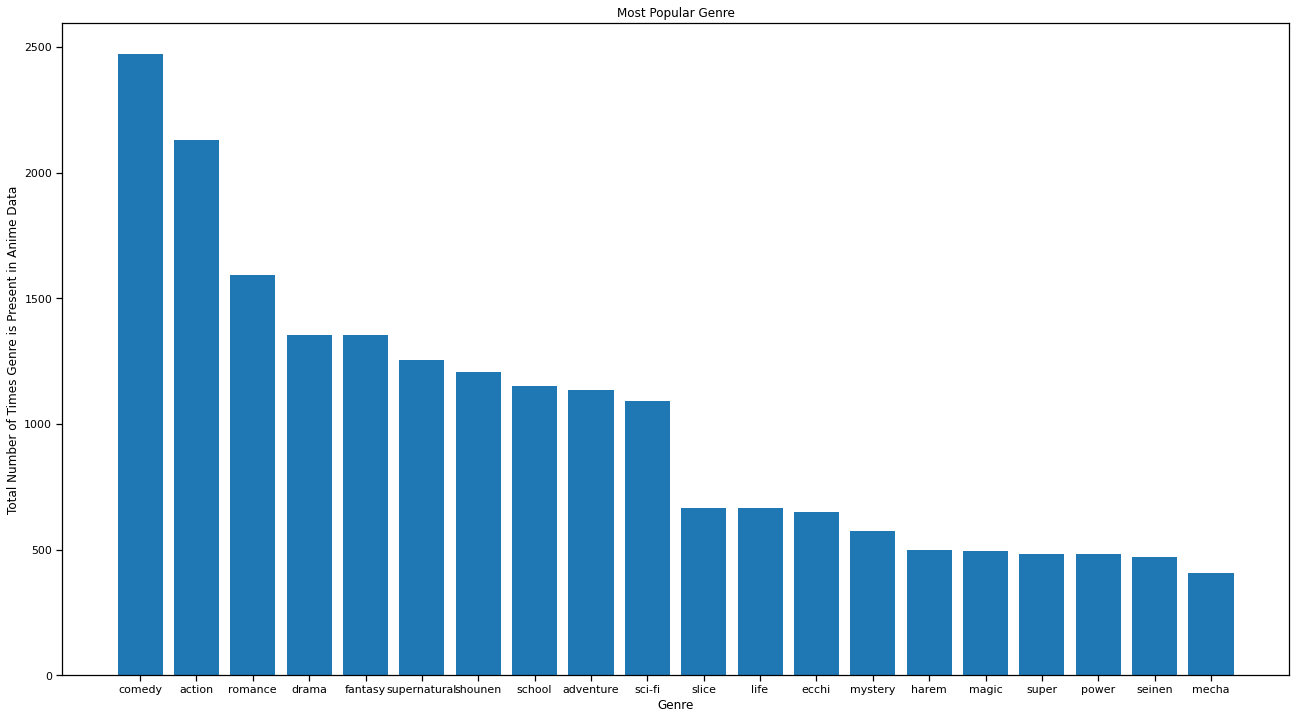

In [203]:
plt.figure(figsize=(22,12))
plt.bar([word[0] for word in most_common_genre], [word[1] for word in most_common_genre])
plt.title("Most Popular Genre")
plt.xlabel("Genre")
plt.ylabel("Total Number of Times Genre is Present in Anime Data")
plt.show()

In [0]:
vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1,2), stop_words=stopwords_list)

In [0]:
tags_list_2 = [' '.join(x) for x in tags_list]

In [0]:
tf_idf_data_train = vectorizer.fit_transform(tags_list_2)

In [207]:
type(tf_idf_data_train)

scipy.sparse.csr.csr_matrix

In [208]:
tf_idf_data_train.shape

(1971, 629)

In [0]:
#instantiate SVD
svd = TruncatedSVD(n_components=500, n_iter=7, random_state=42)

#fit and transform the vectorized tf-idf matrix 
tf_idf_data_train_svd = svd.fit_transform(tf_idf_data_train)

In [210]:
print(svd.explained_variance_ratio_.sum())

0.9954973738489551


In [0]:
#overfit?

# Calculating the similarities between anime with TF-IDF

We are going to perform calculations on the tf-idf matrices that were created above by calculating the dot product for each pairing. This will be equivalent to the cosine similarity score. For tf_idf we will be using sklearn's linear_kernel to obtain this. 

In [0]:
cosine_sim = linear_kernel(tf_idf_data_train_svd, tf_idf_data_train_svd)

In [215]:
cosine_sim.shape

(1971, 1971)

In [0]:
anime_2 = sample.reset_index()

#extract all unique anime titles
anime_id_tag = anime_2['anime_id']

#goal is to extract the anime that correspond to its position within the tf idf vectorizer matrix,
# which we will take similarity scores from later
indices = pd.Series(anime_2.index, index=sample['anime_id'])

In [0]:
def get_most_similar_anime(animeid, n = 20):
  #tf-idf vectorizer score will take anime name from any given id and pair it with the 50 most similar 
  idx = indices[animeid]
  sim_scores = list(enumerate(cosine_sim[idx]))
  sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
  sim_scores = sim_scores[0:n] #not going to do 0 to 51, this will be orginally specified

  anime_indices = [i[0] for i in sim_scores]

  recs = pd.DataFrame(columns= anime_2.columns)
  for i in a_id.loc[anime_indices]:

    if i != name: 
      recs = recs.append(anime_2[anime_2['anime_id'] == i])
  return recs

In [230]:
anime_2[anime_2['anime_id'] == 20]

,index,anime_id,name,genre,type,episodes,rating_x,members,user_id,rating_y
594,582381,20,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,8,683297,4979,7.0
800,582239,20,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,8,683297,4572,7.0
1007,585230,20,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,8,683297,12779,9.0
1133,585042,20,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,8,683297,12263,10.0
2069,583699,20,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,8,683297,8323,7.0
2083,581716,20,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,8,683297,3057,9.0
2355,581174,20,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,8,683297,1522,7.0
2416,580688,20,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,8,683297,166,6.0
2554,582715,20,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,8,683297,5782,7.0
3166,581891,20,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,8,683297,3584,7.0


In [232]:
get_most_similar_anime(20)

IndexError: ignored